# Stepped Impedance Design

This design is done using a 3rd-order Chebyshev I type filter, with a maximum ripple in the passband of 0.1dB, in accordance with Microstrip Filters for RF/Micowave Applications by Jia-Sheng Hong.
<br>
Much of the difficult work obtaining equations is from the aforementioned Microstrip Filters for RF/Micowave Applications by Jia-Sheng Hong. I highly recommend reading it to truly understand the construction of microstrip filters of any kind.
<br>
Notebook written by Ethan Kasaba.
<br>
Revision 1.1

## Imports

In [7]:
from scipy import signal
from scipy.optimize import fsolve
import numpy as np 
import matplotlib.pyplot as plt
import filterFunctions as ff #Useful functions for filter design from this package

## Variables That Can Be Changed

In [8]:
cutoff = 2.5 * 10 ** 9 # cutoff frequency (Hz)
type = 'cheby1' # type of filter (cheby1, butter)
rip = 0.1 # maximum ripple (dB) in pass band for Chebyshev I filter design

#Change these values to match your substrate, and the characteristic impedances of the low- and high-impedance lines
epsilon = 10.8 # relative permittivity of substrate
h = 1.4 # substrate thickness (mm)
z0c = 24 # desired characteristic impedance of low-impendance (capacitive) lines (ohms), 24 ohms chosen based on Hong
z0l = 93 # desired characteristic impedance of high-impendance (inductive) lines (ohms), 93 ohms chosen based on Hong

## Variables That Should Not Be Changed

In [45]:
ord = 3 # order, number of reactive elements in the filter
# Note that the order may be changed to get the g's, but the length calculations have yet to be generalized to other orders
cutoffGHz = cutoff / (10 ** 9) # cutoff frequency conversion (GHz)
cutoffrads = 2 * np.pi * cutoff # cutoff frequency conversion (rads/sec)
g0 = 1 # source impedance, normalized to 1 typically
z0 = 50 # characteristic impedance (ohms), usually 50 ohms for microwave applications
plot_type = 'low' # type of filter: low-pass, this is for the plotting

## Plotting Expected Transfer Function

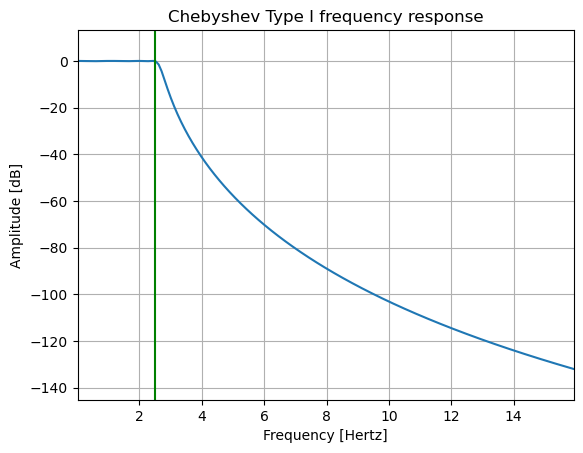

In [46]:
b, a = signal.cheby1(ord, rip, cutoffrads, plot_type, analog=True) # get filter coefficients for plotting
w, x = signal.freqs(b, a) # frequency response for plotting
plt.plot(w / (2 * np.pi)/1e9, 20 * np.log10(abs(x))) # plot frequency response
plt.title('Chebyshev Type I frequency response')
plt.xlabel('Frequency [Hertz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff/1e9, color='green') # cutoff frequency line in green
plt.show()

## Finding the Element Values

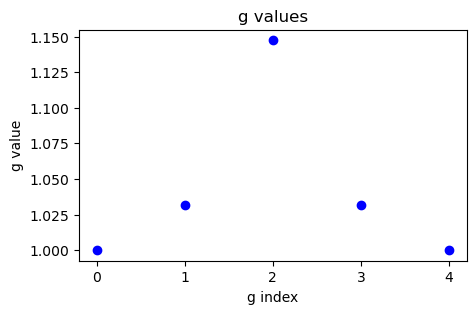

In [14]:
## See filterFunctions.py for the behind-the-scenes calculations, it is quite unwieldy to have them here
gs = ff.findgs(ord, rip, type) # get g's for filter design

fig, ax = plt.subplots(1,1,figsize=(5,3)) # plot g's
ax.plot(gs,'bo')
ax.set_title('g values')
ax.set_xlabel('g index')
ax.set_ylabel('g value')
ax.set_xticks(np.arange(0,ord+2))

## Element Calculation

In [15]:
element = 1 # element number, skipping 0, the source impedance
elements = [] # inductances and capacitances of each element
for g in gs: # iterate through g values, obtain inductance or capacitance
    if g == 1:
        continue
    elif element % 2 == 1:
        out = ff.inductancefromg(z0, g0, cutoff, g)
        print("L" + str(element) +  " = ", out)
    else:
        out = ff.capacitancefromg(z0, g0, cutoff, g)
        print("C" + str(element) +  " = ", out)
    element += 1
    elements.append(out)
L = elements[0] # inductance of first and third element, in the the 3rd order case
C = elements[1] # capacitance of second element

L1 =  3.283637493005715e-09
C2 =  1.4609154737392528e-12
L3 =  3.283637493005715e-09


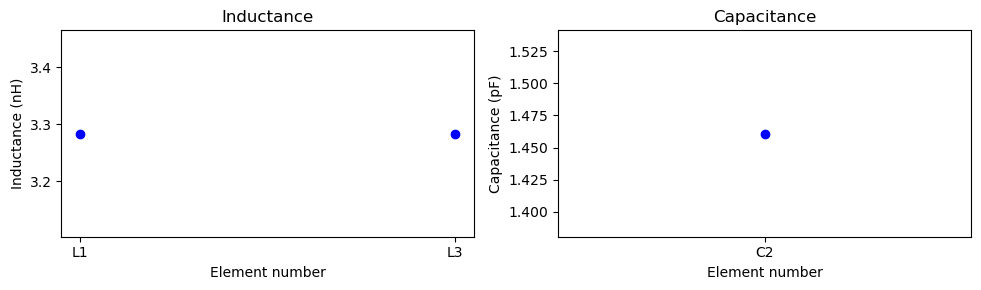

In [33]:
fig,axs = plt.subplots(1,2,figsize=(10,3)) # plot inductance and capacitance
Ls =elements[::2]
Cs = elements[1::2]
axs[0].plot(np.array(Ls)*1e9,'bo')
axs[0].set_title('Inductance')
axs[0].set_xlabel('Element number')
axs[0].set_ylabel('Inductance (nH)') 
x_ticklabels = ['L'+str(2*ii+1) for ii in range(len(Ls))]
axs[0].set_xticks(np.arange(len(Ls)))
axs[0].set_xticklabels(x_ticklabels)

axs[1].plot(np.array(Cs)*1e12,'bo')
axs[1].set_title('Capacitance')
axs[1].set_xlabel('Element number')
axs[1].set_ylabel('Capacitance (pF)')
x_ticklabels = ['C'+str(2*ii+2) for ii in range(len(Cs))]
axs[1].set_xticks(np.arange(len(Cs)))
axs[1].set_xticklabels(x_ticklabels)

plt.tight_layout()

# ax.plot(elements,'bo')
# ticks = []
# for ii,elem in enumerate(elements):
#     if ii % 2 == 0: ticks.append('L' + str(ii+1))
#     elif ii % 2 == 1: ticks.append('C' + str(ii+1))

# ax.set_xticks(np.arange(len(elements)))
# ax.set_xticklabels(ticks)

## Finding the Element Lengths, Only Works for 3rd Order

In [16]:
effepsilons = [] # effective permittivity for each element
effepsilons.append(ff.geteffepsilon(epsilon, ff.findulessthan2(epsilon, z0l))) # effective permittivity, for inductor
effepsilons.append(ff.effepsilon(epsilon, ff.findumorethan2(epsilon, z0c))) # effective permittivity, for capacitor
effepsilons.append((epsilon, ff.findulessthan2(epsilon, z0))) # effective permittivity, for source impedance

lambdas = [] # guided wavelength for each element
lambdas.append(ff.findlambda(cutoffGHz, effepsilons[0])) # guided wavelength for inductor (mm)
lambdas.append(ff.findlambda(cutoffGHz, effepsilons[1])) # guided wavelength for capacitor (mm)
lambdas.append(ff.findlambda(cutoffGHz, effepsilons[2])) # guided wavelength for source impedance (mm)

def func(x): # system of equations to solve for x = [lL, lC], Hong p. 114
    return [z0l * np.sin((2 * np.pi * x[0]) / lambdas[0]) + z0c * np.tan((np.pi * x[1]) / lambdas[1]) - cutoffrads * L,
            (1 / z0c) * np.sin((2 * np.pi * x[1]) / lambdas[1]) + (2 / z0l) * np.tan(np.pi * x[0] / lambdas[0]) - cutoffrads * C]
lengths = fsolve(func, [0.01, 0.01]) # solve for lL and lC, the lengths of the inductive and capacitive elements, respectively

i = 0 # counter for printing out lengths
for length in lengths: # print out lengths of inductive and capacitive elements
    if i % 2 == 0:
        print("The lengths of the inductive elements are: " + str(length) + " mm")
    else:
        print("The lengths of the capacitive elements are: " + str(length) + " mm")
    i += 1
# print("The guided wavelength for the inductive elements is: " + str(lambdal) + " mm")
# print("The guided wavelength for the capacitive elements is: " + str(lambdac) + " mm")
# print("The guided wavelength for the source impedance is: " + str(lambda0) + " mm")

The lengths of the inductive elements are: 3.8957637806919028 mm
The lengths of the capacitive elements are: 2.8549063576776073 mm


## Finding the Element Widths, Same as Above

In [8]:
ws = [] # widths of each element
ws.append(h * ff.findulessthan2(epsilon, z0l)) # width of high-impedance line (mm)
ws.append(h * ff.findumorethan2(epsilon, z0c)) # width of low-impedance line (mm)
ws.append(h * ff.findulessthan2(epsilon, z0)) # width of source impedance (mm)

print("The widths of the inductive elements are: " + str(ws[0]) + " mm")
print("The widths of the capacitive elements are: " + str(ws[1]) + " mm")
# print("The width of the source impedance is: " + str(ws[2]) + " mm")

The widths of the inductive elements are: 0.21272005067174096 mm
The widths of the capacitive elements are: 4.3395632556119805 mm
